In [37]:
from ceruleanml import data
from ceruleanml import eval
from icevision.parsers import COCOMaskParser
from icevision.data import SingleSplitSplitter
from fastai.data.block import DataBlock
from fastai.vision.data import ImageBlock, MaskBlock
from fastai.vision.augment import aug_transforms
from fastai.vision.learner import unet_learner
from fastai.data.transforms import RandomSplitter
from fastai.metrics import Dice
from ceruleanml.coco_load_fastai import record_collection_to_record_ids, get_image_path, record_to_mask
from torchvision.models import resnet18, resnet34, resnet50
from fastai.callback.fp16 import MixedPrecision
from fastai.callback.tensorboard import TensorBoardCallback
from datetime import datetime
from pathlib import Path
import os
from sklearn.metrics import confusion_matrix, f1_score
import skimage.io as skio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)
import matplotlib.image as mpimg

### Parsing COCO Dataset with Icevision

In [2]:
data_path = "/root/"
mount_path = "/root/data"

In [3]:
size = 64  # Progressive resizing could happen here
augs = aug_transforms(flip_vert=True, max_warp=0.1, size=size)
class_map = {v: k for k, v in data.class_mapping_coco_inv.items()}
class_ints = list(range(1, len(list(class_map.keys())[:-1]) + 1))
parser = COCOMaskParser(annotations_filepath=f"{mount_path}/tile-cerulean-v2-partial-with-context/instances_Tiled Cerulean Dataset V2.json", img_dir=f"{mount_path}/tile-cerulean-v2-partial-with-context/tiled_images")
train_records, valid_records = parser.parse(autofix=False)

  0%|          | 0/3883 [00:00<?, ?it/s]

### Importing functions for returning an image sample and a semantic segmentation label for each sample

In [4]:
record_ids = record_collection_to_record_ids(train_records)

### Constructing a FastAI DataBlock that uses parsed COCO Dataset from icevision parser+

In [5]:
def get_image_by_record_id(record_id):
    return get_image_path(train_records, record_id)
def get_mask_by_record_id(record_id):
    return record_to_mask(train_records, record_id)

In [6]:
coco_seg_dblock = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes=class_ints)),
    get_x=get_image_by_record_id,
    splitter=RandomSplitter(),
    get_y=get_mask_by_record_id,
    batch_tfms=aug_transforms(),
    n_inp=1,
)

dls = coco_seg_dblock.dataloaders(source=record_ids, batch_size=5)

/root/miniconda3/envs/fastai2/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


### Fastai2 Trainer

In [7]:
dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%d_%b_%Y_%H_%M_%S")
experiment_dir =  Path(f'{mount_path}/experiments/cv2/'+timestampStr+'_fastai_unet/')
experiment_dir.mkdir(exist_ok=True)

In [8]:
arch = 18
archs = {18: resnet18, 34: resnet34, 50: resnet50}

epoch,train_loss,valid_loss,dice,time
0,0.150836,0.177775,0.000000,06:36


epoch,train_loss,valid_loss,dice,time
0,0.112745,0.161511,0.000000,06:46


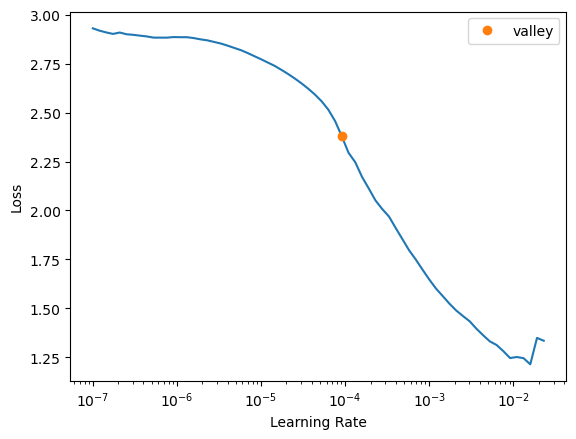

In [9]:
learn = unet_learner(dls, archs[arch], metrics=[Dice()], model_dir=experiment_dir, n_out = 7) # cbs=[MixedPrecision]

lr = learn.lr_find()

cbs = [TensorBoardCallback(projector=False, trace_model=False)]

learn.fine_tune(1, 2e-4, cbs=cbs)#, cbs=SaveModelCallback(monitor='dice'))w

In [13]:
Dice??

Init signature: Dice(axis=1)
Source:        
class Dice(Metric):
    "Dice coefficient metric for binary target in segmentation"
    def __init__(self, axis=1): self.axis = axis
    def reset(self): self.inter,self.union = 0,0
    def accumulate(self, learn):
        pred,targ = flatten_check(learn.pred.argmax(dim=self.axis), learn.y)
        self.inter += (pred*targ).float().sum().item()
        self.union += (pred+targ).float().sum().item()

    @property
    def value(self): return 2. * self.inter/self.union if self.union > 0 else None
File:           ~/miniconda3/envs/fastai2/lib/python3.9/site-packages/fastai/metrics.py
Type:           type
Subclasses:     JaccardCoeff


In [10]:
validation = learn.validate()

In [12]:
learn.validate??

Signature: learn.validate(ds_idx=1, dl=None, cbs=None)
Docstring: Validate on `dl` with potential new `cbs`.
Source:   
    def validate(self, ds_idx=1, dl=None, cbs=None):
        if dl is None: dl = self.dls[ds_idx]
        with self.validation_context(cbs=cbs): self._do_epoch_validate(ds_idx, dl)
        return getattr(self, 'final_record', None)
File:      ~/miniconda3/envs/fastai2/lib/python3.9/site-packages/fastai/learner.py
Type:      method


In [11]:
validation

(#2) [0.09027573466300964,0.4928151107030078]

In [13]:
savename = f'{arch}_{size}_{round(validation[1],3)}.pkl'
learn.export(f'{experiment_dir}/{savename}')

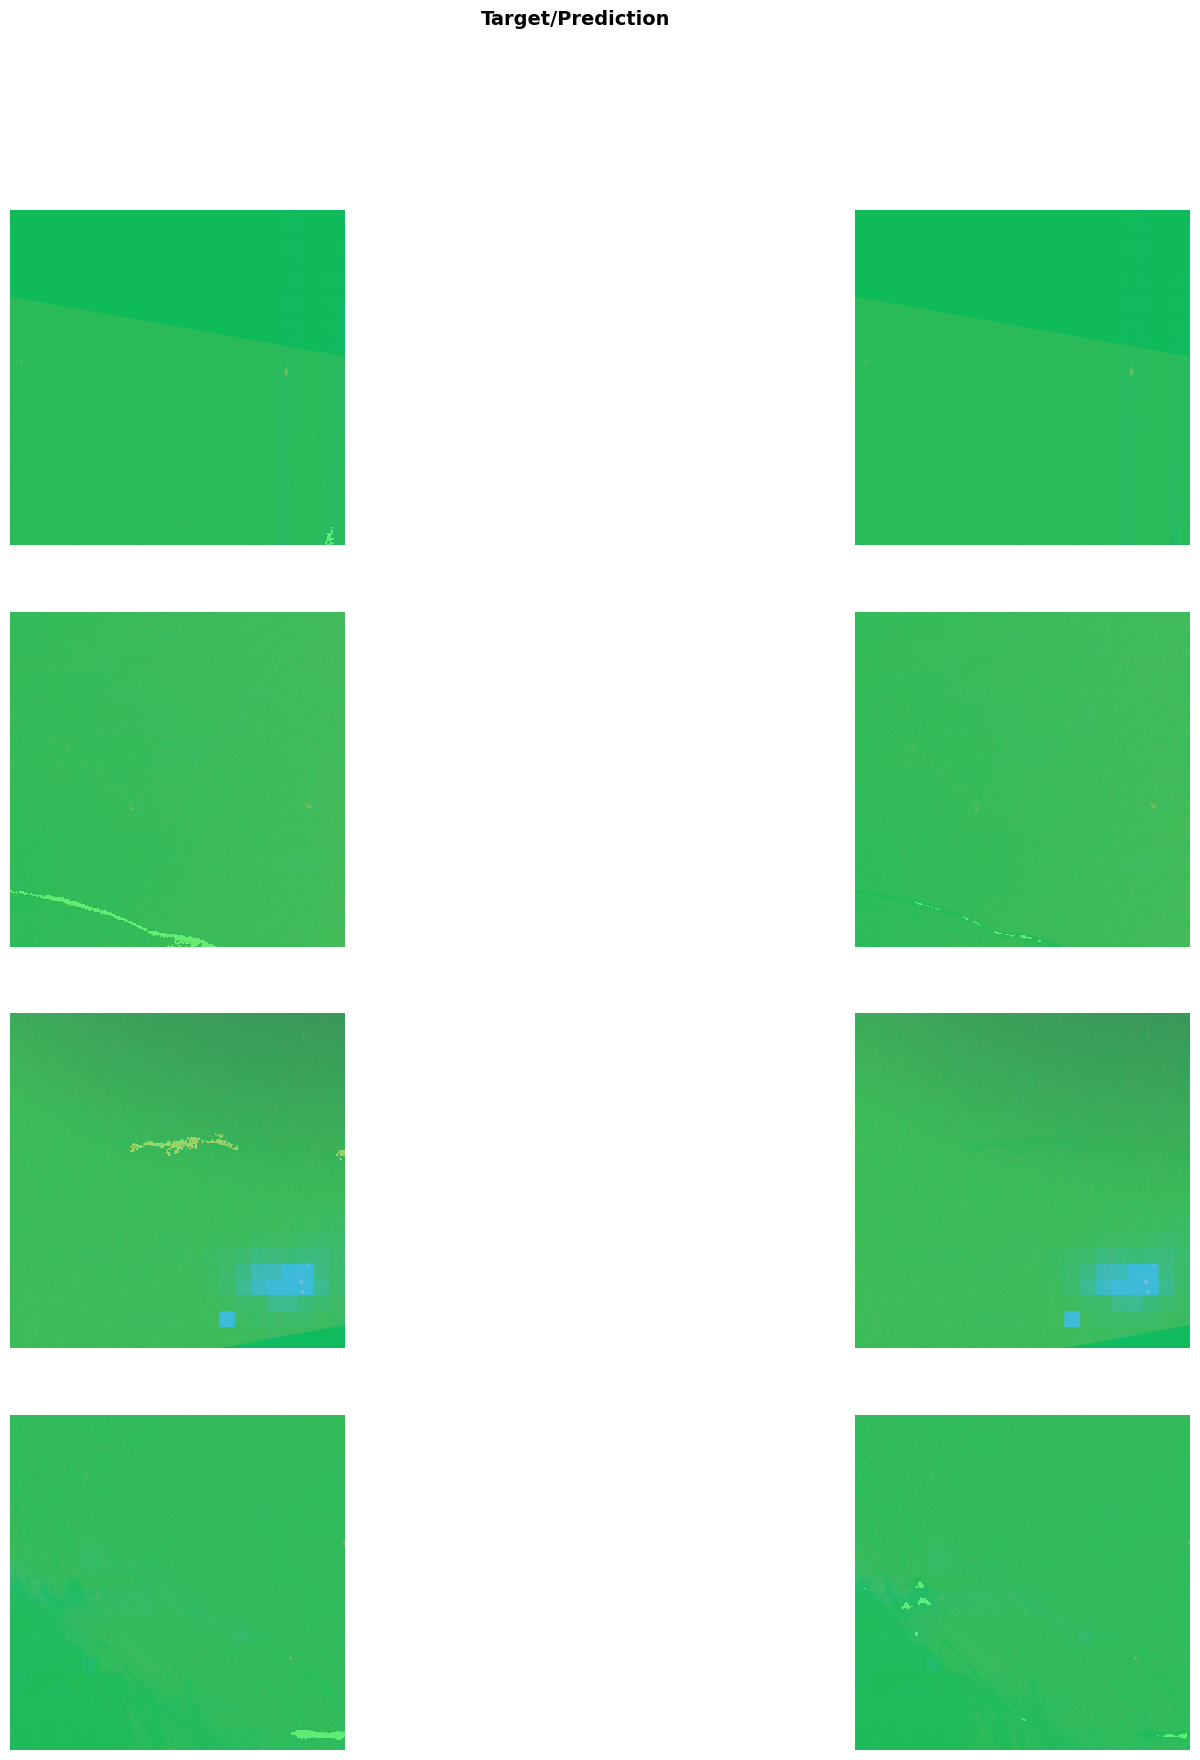

In [18]:
learn.show_results(max_n=4, figsize=(20,20), vmin=0, vmax=3)

In [ ]:
ls {modelpath}

In [ ]:
learn.show_results(max_n=4, figsize=(20,20), vmin=0, vmax=3)

Default path for tensorboard logs is `./runs/`

In [ ]:
!ls './runs/'

Copy logs to appropriate exeriments folder in the mounted GCS volume.

In [ ]:
!cp -R './runs/' {modelpath}'/tensorboard/'

Now, run the following from anywhere with gcs authenticated:

In [19]:
!tensorboard --logdir="./runs"


TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.9.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [25]:
val_record_ids = record_collection_to_record_ids(valid_records)
pred_arrs = []
val_arrs = []
with learn.no_logging():
    for v, i in zip(range(len(val_record_ids[0:10])), val_record_ids[0:10]):
        v = valid_records[v].as_dict()
        v_masks = v['detection']['masks'][0].to_mask(v['common']['height'],v['common']['width']).data
        p = get_image_path(valid_records,i)
        arr = skio.imread(p)
        pred_arr = learn.predict(arr)
        pred_arr = pred_arr[0]
        pred_arr = pred_arr.cpu().detach().numpy()
        pred_arrs.append(pred_arr)
        val_arrs.append(v_masks)

In [26]:
pred_arrs, val_arrs

([array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]),
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]),
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]),
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]),
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
    

In [24]:
len(train_records)

2414

In [ ]:
dir(learn)

/root/work/ceruleanml/eval_1.py:38: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


(array([[    0.99329,   0.0067146,           0,           0,           0,           0],
        [        nan,         nan,         nan,         nan,         nan,         nan],
        [        nan,         nan,         nan,         nan,         nan,         nan],
        [        nan,         nan,         nan,         nan,         nan,         nan],
        [        nan,         nan,         nan,         nan,         nan,         nan],
        [        nan,         nan,         nan,         nan,         nan,         nan]]),
 0.4983156877012094)

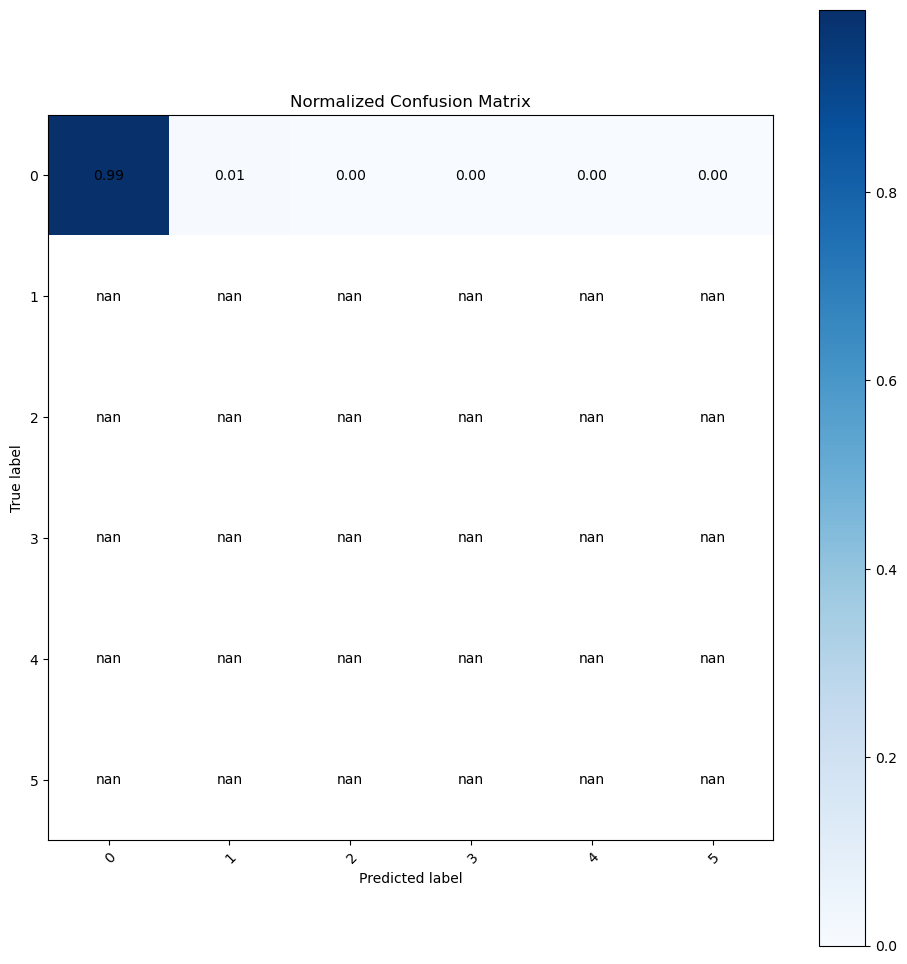

In [38]:
eval.cm_f1(val_arrs, pred_arrs, 6, mount_path)